In [5]:
#importing libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime
from scipy.stats import skew  # for some statistics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn.linear_model as linear_model
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import os
#print(os.listdir("../input"))

import warnings
warnings.filterwarnings('ignore')

In [6]:
data = pd.read_csv("Data/train_processed.csv")

In [7]:
data.head()

,id,title,item_condition,item_type,item_brand,price,shipping_category,description,item_characteristic_n,item_characteristic_p,item_origin,item_flag_available,post_stats,approved_poster
0,1459601,UBWY Tbpty Zpbh3gbpnzrpw Wrf Fbrxt,1,Beauty/Makeup/Lips,Tbpty,13.0,1,Ujbaf Dbarwg USWN SOT WRARTYN YNRTRSX IPBXN XY...,10.138889,48,4,0,22976,False
1,1334924,Uywdry utrcq,2,Electronics/Cameras & Photography/Camera & Pho...,NaN,3.0,1,Iwbcq Gsouy uywdry utrcq. Yltyxnbiwy. Fwozu rx...,5.198556,18,3,0,147631,False
2,215759,Tbxzyprxy Issq,3,Other/Books/Literature & Fiction,NaN,7.0,1,FPRCY DRPA XS WYUU Tbxzyprxy ig Ynjbpn Iwssp P...,8.351304,18,5,0,1266811,False
3,964284,Cpyj xycq,3,Women/Sweaters/Crewneck,NaN,10.0,1,Xs nyucprftrsx gyt,6.849827,16,7,0,518287,False
4,1159166,UOFYPUBWY 2016 XYJ IWOYTSSTM UABPT JBTCM,1,Electronics/Cell Phones & Accessories/Cell Pho...,NaN,28.0,1,* Xyj 100% rx Pytbrw Isl * Mrzm-vobwrtg abny *...,3.674306,56,2,0,323393,False


In [8]:
#describe dataset
print (f"Dataset has {data.shape[0]} rows and {data.shape[1]} columns")

Dataset has 1482535 rows and 14 columns


In [9]:
#descriptive statistic of dataset
data.describe()

,id,item_condition,price,shipping_category,item_characteristic_n,item_characteristic_p,item_origin,item_flag_available,post_stats
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01,5.163722e+01,2.500217e+01,4.002040e+00,9.982631e-02,7.412920e+05
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01,2.099458e+02,1.802960e+01,1.414320e+00,2.997684e-01,4.279711e+05
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,2.725540e-03,0.000000e+00,0.000000e+00,0.000000e+00,1.200000e+01
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00,3.868460e+00,1.000000e+01,3.000000e+00,0.000000e+00,3.706620e+05
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00,1.217400e+01,2.100000e+01,4.000000e+00,0.000000e+00,7.412920e+05
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00,3.838470e+01,3.600000e+01,5.000000e+00,0.000000e+00,1.111924e+06
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00,4.770192e+04,1.620000e+02,8.000000e+00,1.000000e+00,1.482568e+06


In [10]:
#exploring the data
data.dtypes

id                         int64
title                     object
item_condition             int64
item_type                 object
item_brand                object
price                    float64
shipping_category          int64
description               object
item_characteristic_n    float64
item_characteristic_p      int64
item_origin                int64
item_flag_available        int64
post_stats                 int64
approved_poster             bool
dtype: object

In [11]:
#tarnsforming the approved_poste column using integer encoding
data.approved_poster = data.approved_poster.apply(lambda x: 1 if x == True else 0)

In [12]:
# we have an Id variable, that we should not use for predictions:
print('Number of Id labels: ', len(data.id.unique()))
print('Number of Listings in the Dataset: ', len(data))

Number of Id labels:  1482535
Number of Listings in the Dataset:  1482535


Id is a unique identifier for each of the listings. Thus this is not a variable that we can use as a predictor.

### Handling Missing Data

In [13]:
#how many missing data do we have in our data set?
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
item_brand,632682,42.675687
item_type,6327,0.426769
description,4,0.000270
approved_poster,0,0.000000
post_stats,0,0.000000
item_flag_available,0,0.000000
item_origin,0,0.000000
item_characteristic_p,0,0.000000
item_characteristic_n,0,0.000000
shipping_category,0,0.000000


From the above missing data analysis we observed the varaible <strong>item_brand </strong> has a lot of missing iformation, <strong>42% of the data set with 632682 </strong>. I decided to drop the feature since it is a categorical variable with very high cardinality.

In the case <strong> item_type and description</strong> since only <strong> 0.42% and 0.00027% respectively</strong> of the observation are missing I decided to delete the observations and keep the varaibles.

In [14]:
#dealing with missing data
data = data.drop((missing_data[missing_data['Total'] > 6327]).index,1)
data = data.drop(data.loc[data['item_type'].isnull()].index)
data = data.drop(data.loc[data['description'].isnull()].index)
print('Total number of missing data', data.isnull().sum().max()) #just checking that there's no missing data missing...

Total number of missing data 0


## Feature Engineering 
The item_type feature possses the opportunity of creating addition feature that may best capture more information about our data set. I decided to split the feature into 3 extra categories.

In [15]:
#split the item_type column into 3 seperate categories
new = data['item_type'].str.split("/", n = 2, expand = True)
#create new features
data['item_type_a'] = new[0]
data['item_type_b'] = new[1]
data['item_type_c'] = new[2]
data.drop(columns = ['item_type'], inplace = True )

### Finding Categorical, Discrete and Numerical variables

In [16]:
# find categorical variables
categorical = [var for var in data.columns if data[var].dtype=='O']
print('There are {} categorical variables'.format(len(categorical)))
# make a list of the numerical variables 
numerical = [var for var in data.columns if data[var].dtype!='O']
print('There are {} numerical variables'.format(len(numerical)))

There are 5 categorical variables
There are 10 numerical variables


In [17]:
categorical

['title', 'description', 'item_type_a', 'item_type_b', 'item_type_c']

In [18]:
# let's visualise the values of the discrete variables
discrete = []

for var in numerical:
    if len(data[var].unique()) < 20:
        print(var, ' values: ', data[var].unique())
        discrete.append(var)
print()
print('There are {} discrete variables'.format(len(discrete)))

item_condition  values:  [1 2 3 4 5]
shipping_category  values:  [1 0]
item_origin  values:  [4 3 5 7 2 6 1 0 8]
item_flag_available  values:  [0 1]
approved_poster  values:  [0 1]

There are 5 discrete variables


In [19]:
# find continuous variables
# let's remember to skip the Id variable and the target variable Price
# which are both also numerical

numerical = [var for var in numerical if var not in discrete and var not in [
    'id', 'price']]

print('There are {} numerical and continuous variables'.format(len(numerical)))

There are 3 numerical and continuous variables


Perfect!! Now we have inspected and have a view of the different types of variables that we have in the house price dataset. Let's move on to understand the types of problems that these variables have.

## Exploratory data Analysis
### Outliers and distribution

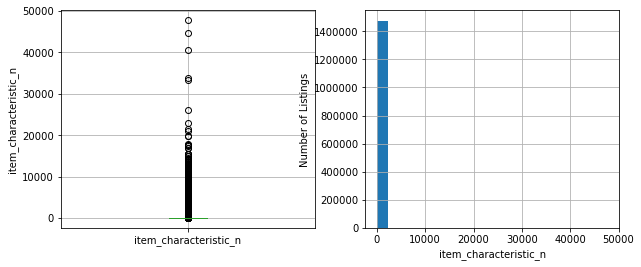

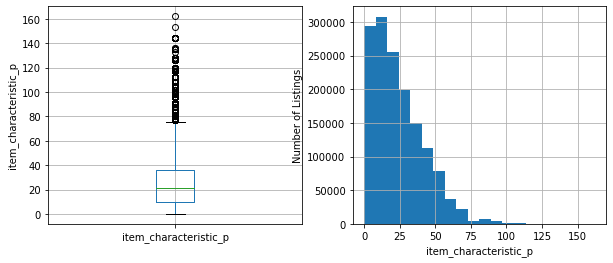

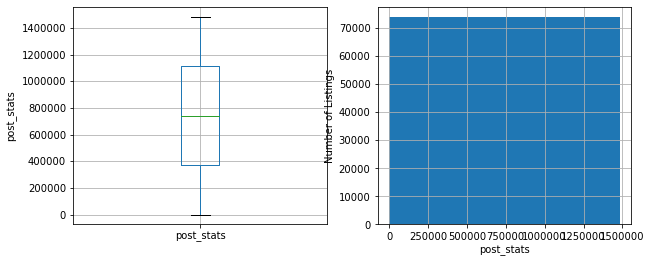

In [20]:
# let's make boxplots to visualise outliers in the continuous variables 
# and histograms to get an idea of the distribution
for var in numerical:
    if var != 'id':
        plt.figure(figsize=(10,4))
        plt.subplot(1, 2, 1)
        fig = data.boxplot(column=var)
        fig.set_title('')
        fig.set_ylabel(var)

        plt.subplot(1, 2, 2)
        fig = data[var].hist(bins=20)
        fig.set_ylabel('Number of Listings')
        fig.set_xlabel(var)


The majority of the continuous variables seem to contain outliers. In addition, the majority of the variables are not normally distributed. As we are planning to build a linear model, we need to tackle these to improve the model performance. 

In [21]:
def plotting_3_chart(df, feature):
    ## Importing seaborn, matplotlab and scipy modules. 
    import seaborn as sns
    import matplotlib.pyplot as plt
    import matplotlib.gridspec as gridspec
    from scipy import stats
    import matplotlib.style as style
    style.use('fivethirtyeight')

    ## Creating a customized chart. and giving in figsize and everything. 
    fig = plt.figure(constrained_layout=True, figsize=(15,10))
    ## creating a grid of 3 cols and 3 rows. 
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)
    #gs = fig3.add_gridspec(3, 3)

    ## Customizing the histogram grid. 
    ax1 = fig.add_subplot(grid[0, :2])
    ## Set the title. 
    ax1.set_title('Histogram')
    ## plot the histogram. 
    sns.distplot(df.loc[:,feature], norm_hist=True, ax = ax1)

    # customizing the QQ_plot. 
    ax2 = fig.add_subplot(grid[1, :2])
    ## Set the title. 
    ax2.set_title('QQ_plot')
    ## Plotting the QQ_Plot. 
    stats.probplot(df.loc[:,feature], plot = ax2)

    ## Customizing the Box Plot. 
    ax3 = fig.add_subplot(grid[:, 2])
    ## Set title. 
    ax3.set_title('Box Plot')
    ## Plotting the box plot. 
    sns.boxplot(df.loc[:,feature], orient='v', ax = ax3 );
    


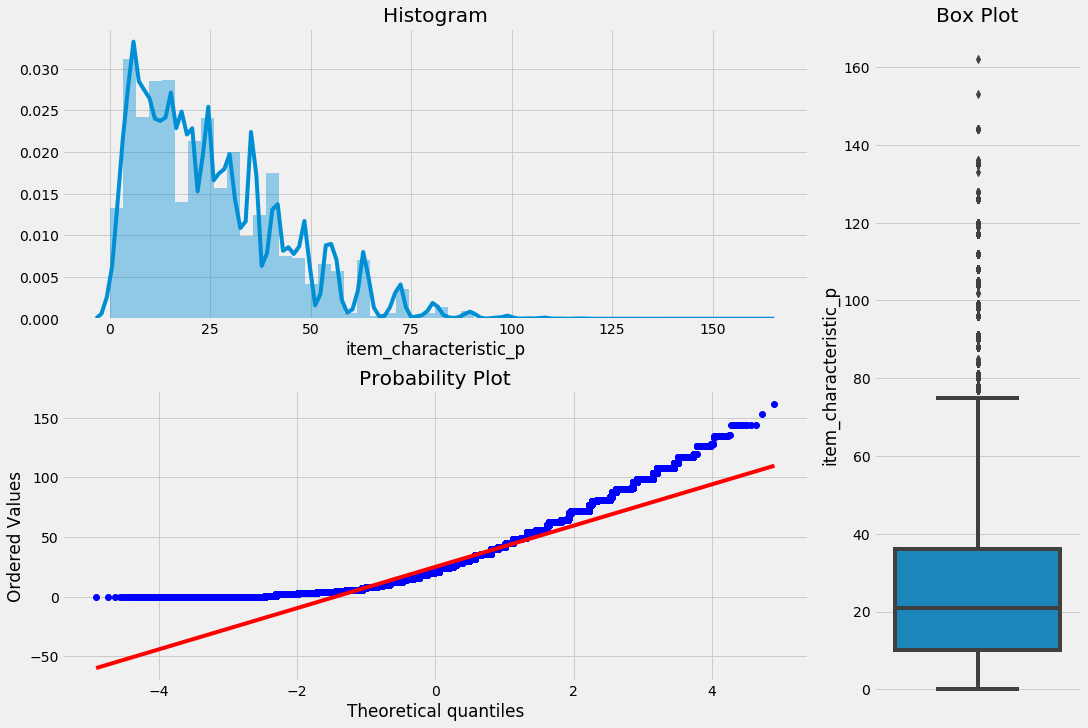

In [56]:
plotting_3_chart(data, 'item_characteristic_p')

I want to focus on the target variable which is Price. Let's create a histogram to see if the target variable is Normally distributed. If we want to create any linear model, it is essential that the features are normally distributed. This is one of the assumptions of multiple linear regression. 

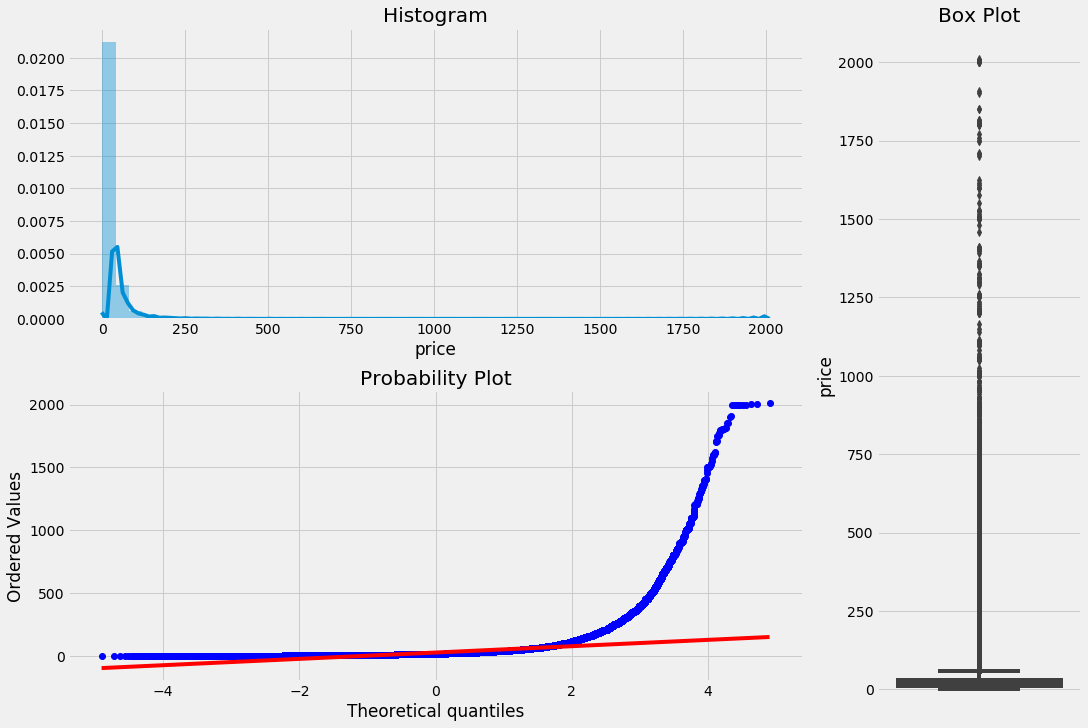

In [22]:
plotting_3_chart(data, 'price')

This three charts above describes a lot about our target variable
<ul>Our target variable, price is not normally distributed.</ul>
<ul>Our target variable is right skewed</ul>
<ul>There are multiple ouliers in the variable</ul>
<ul>Our target variable is postive skewed which the tail on the right side of the distribution is longer and fatter</ul>

In [23]:
#skewness and kurtosis
print("Skewness: " + str(data['price'].skew()))
print("Kurtosis: " + str(data['price'].kurt()))

Skewness: 11.398957184706825
Kurtosis: 284.0687160144006


The linear regression analysis requires the dependent variable to be multivariate normally distributed. A histogram or a Q-Q-Plot can check whether the target variable is normally distributed or not. The goodness of fit test, e.g., the Kolmogorov-Smirnov test or can check for normality in the dependent variable. We already know that our target variable does not follow a normal distribution. Now, let's make sure that the target variable follows a normal distribution. We can try two approaches 

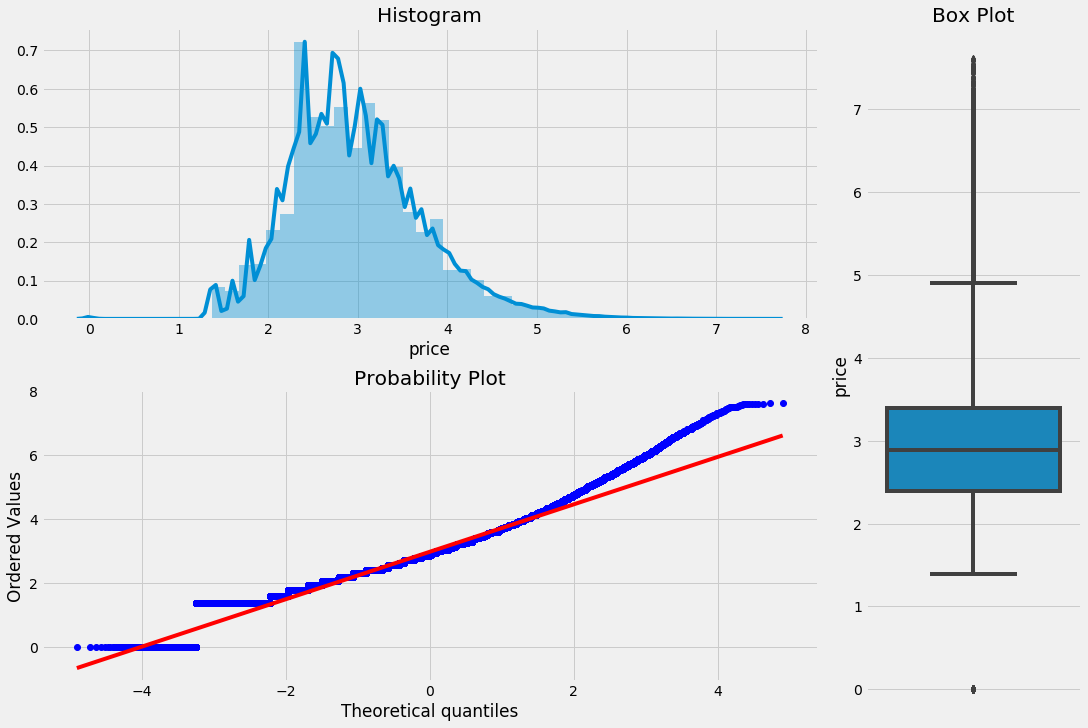

In [24]:
## trainsforming target variable using logrithimic transformation,
transformed_target = np.log1p(data["price"])
data_tdf = pd.DataFrame(transformed_target, columns = ['price'])
## Plotting the newly transformed response variable
plotting_3_chart(data_tdf, 'price')

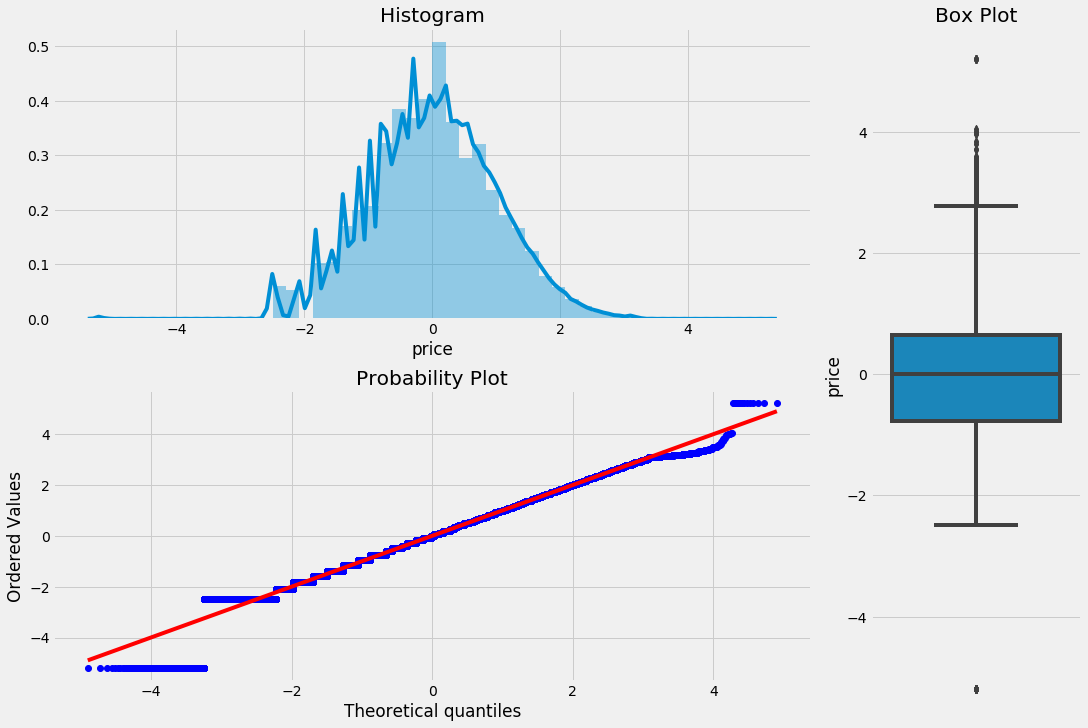

In [25]:
#converting the target varaible to a normal distribution using Quantile Transformer
from sklearn.preprocessing import QuantileTransformer
transformed_target = data['price']
Transformer = QuantileTransformer(output_distribution='normal',random_state=42)
transformed_target = Transformer.fit_transform(np.array(transformed_target).reshape(-1,1))
transformed_target = np.ravel(transformed_target)
data_tdf = pd.DataFrame(transformed_target, columns = ['price'])
plotting_3_chart(data_tdf, 'price')

From both Above techniques we observe quantile transformer performed better in achieving a normal distribution

In [26]:
data['price'] = pd.Series(transformed_target)

In [27]:
(data.corr()**2)["price"].sort_values(ascending = False)[1:]

shipping_category        1.989712e-06
item_characteristic_p    1.364956e-06
item_characteristic_n    1.313477e-06
item_origin              1.036819e-06
post_stats               6.472206e-07
id                       6.471712e-07
item_flag_available      3.598626e-07
item_condition           1.259301e-08
approved_poster          8.212988e-09
Name: price, dtype: float64

### Does multicollinearity exist?: 
Multicollinearity is when there is a strong correlation between independent variables. Linear regression or multilinear regression requires independent variables to have little or no similar features. Multicollinearity can lead to a variety of problems, including:

<ul>The effect of predictor variables estimated by our regression will depend on what other variables are included in our model.</ul>
<ul>Predictors can have wildly different results depending on the observations in our sample, and small changes in samples can result in very different estimated effects.</ul>
<ul>With very high multicollinearity, the inverse matrix, the computer calculates may not be accurate.</ul>
<ul>We can no longer interpret a coefficient on a variable as the effect on the target of a one-unit increase in that variable holding the other variables constant. The reason behind that is, when predictors are strongly correlated, there is not a scenario in which one variable can change without a conditional change in another variable.</ul>
Heatmap is an excellent way to identify whether there is multicollinearity or not. The best way to solve multicollinearity is to use regularization methods like Ridge or Lasso.

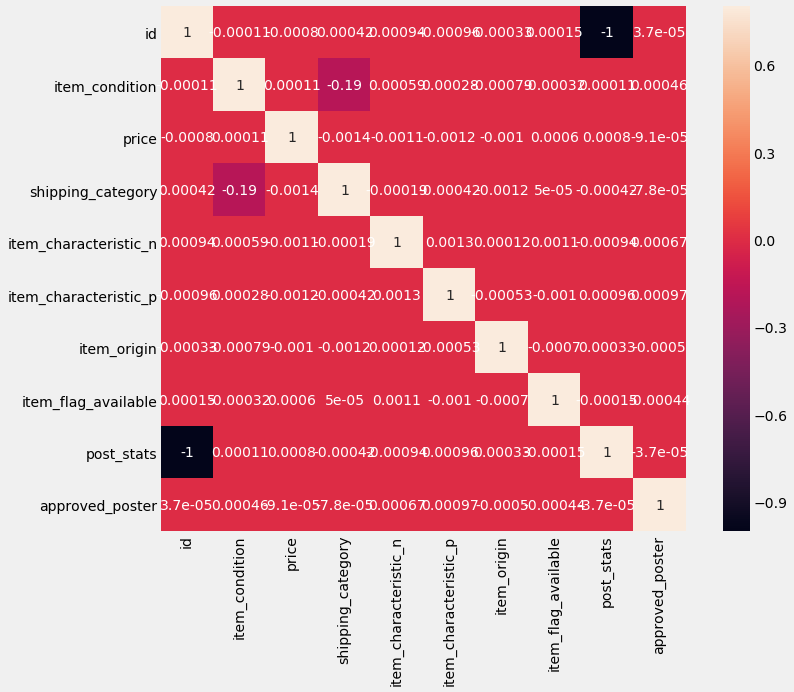

In [28]:
#Data Exploration
#correlation matrix
corrmat = data.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True, annot=True);

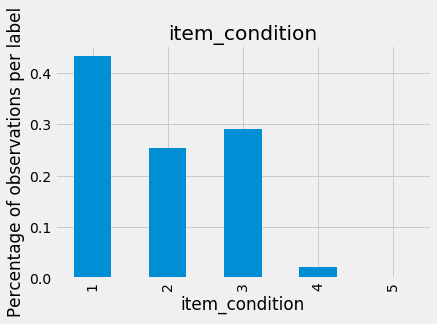

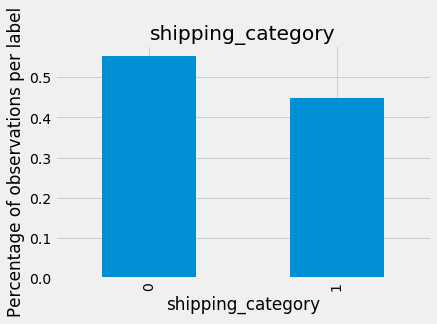

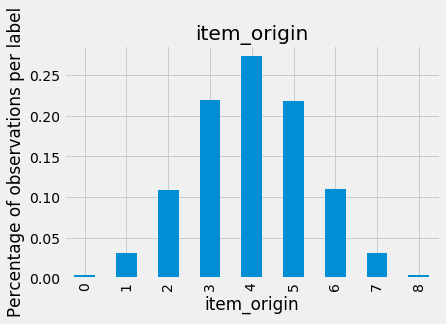

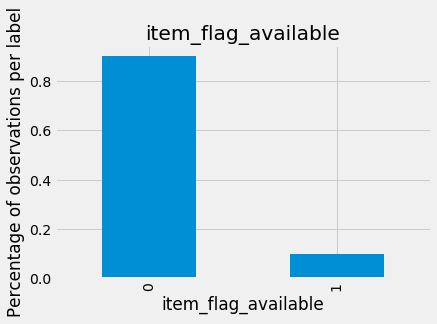

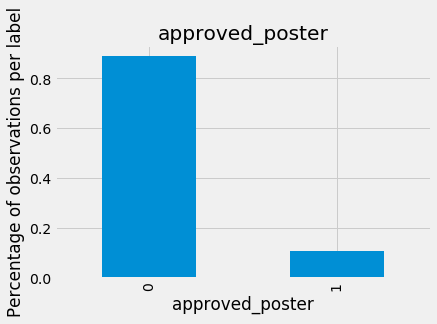

In [29]:
# outlies in discrete variables

for var in discrete:
    (data.groupby(var)[var].count() / np.float(len(data))).plot.bar()
    plt.ylabel('Percentage of observations per label')
    plt.title(var)
    plt.show()

Text(0, 0.5, 'Number of different categories')

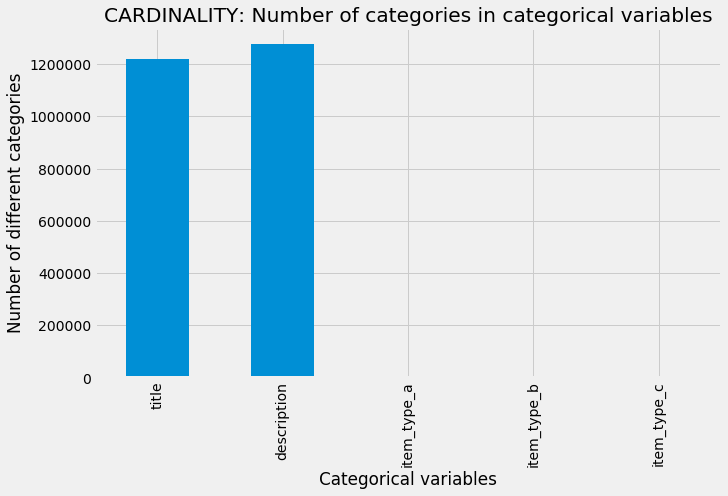

In [30]:
# plot number of categories per categorical variable

data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')

(0, 2000)

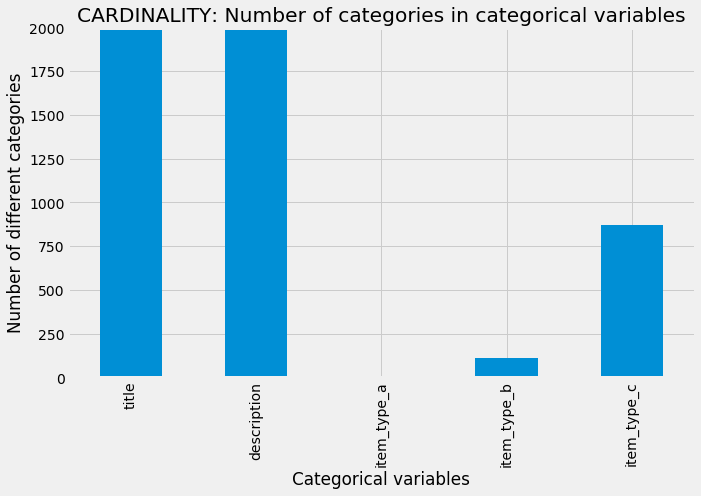

In [31]:
#to observe other categories reduce the limit on the X asis
data[categorical].nunique().plot.bar(figsize=(10,6))
plt.title('CARDINALITY: Number of categories in categorical variables')
plt.xlabel('Categorical variables')
plt.ylabel('Number of different categories')
plt.ylim(0,2000)

In [32]:
print("Cardinality")
print(f' Item_type_a : {len(data.item_type_a.unique())}')
print(f' title : {len(data.title.unique())}')
print(f' description : {len(data.description.unique())}')
print(f' Item_type_b : {len(data.item_type_b.unique())}')
print(f' Item_type_c : {len(data.item_type_c.unique())}')

Cardinality
 Item_type_a : 10
 title : 1220177
 description : 1276149
 Item_type_b : 113
 Item_type_c : 871


We see that most categorical variable have very high cardinality except the <strong>item_type_a</strong> variable. I decided to drop other feature as they may not pose enough valubale information for our model.

In [33]:
#investigating label in the item_type_a feature
data.item_type_a.value_counts()

Women                     664383
Beauty                    207827
Kids                      171688
Electronics               122690
Men                        93680
Home                       67871
Vintage & Collectibles     46530
Other                      45351
Handmade                   30842
Sports & Outdoors          25342
Name: item_type_a, dtype: int64

In [34]:
# categorical = [var for var in data.columns if data[var].dtype == 'O']
# categorical

In [35]:
feature_to_drop = []
for var in categorical:
    if len(data[var].unique()) > 10:
        feature_to_drop.append(var)
        
for var in feature_to_drop:
    categorical.remove(var)

print(categorical)
print(feature_to_drop)



['item_type_a']
['title', 'description', 'item_type_b', 'item_type_c']


In [36]:
#dropping unnecessary features 
data.drop(columns=feature_to_drop, inplace=True)
data.head()

,id,item_condition,price,shipping_category,item_characteristic_n,item_characteristic_p,item_origin,item_flag_available,post_stats,approved_poster,item_type_a
0,1459601,1,-0.393847,1,10.138889,48,4,0,22976,0,Beauty
1,1334924,2,-2.483413,1,5.198556,18,3,0,147631,0,Electronics
2,215759,3,-1.381364,1,8.351304,18,5,0,1266811,0,Other
3,964284,3,-0.768075,1,6.849827,16,7,0,518287,0,Women
4,1159166,1,0.616541,1,3.674306,56,2,0,323393,0,Electronics


In [37]:
data.drop('id',axis=1, inplace=True)
data['item_condition'] = data['item_condition'].astype('category')
data['item_origin'] = data['item_origin'].astype('category')
data['shipping_category'] = data['shipping_category'].astype('category')
data['item_origin'] = data['item_origin'].astype('category')
data['approved_poster'] = data['approved_poster'].astype('category')
data['item_flag_available'] = data['item_flag_available'].astype('category')

In [38]:
#Categorical column encoding using Pd . get Dummies
final_features = pd.get_dummies(data).reset_index(drop=True)
final_features.shape

(1476204, 34)

In [39]:
#splitting variable into features and Target
features = final_features.drop('price', axis=1)
target = transformed_target


In [40]:
features.shape, target.shape

((1476204, 33), (1476204,))

In [41]:
## Train test s
from sklearn.model_selection import train_test_split
## Train test split follows this distinguished code pattern and helps creating train and test set to build machine learning. 
X_train, X_test, y_train, y_test = train_test_split(features, target,
                                                    test_size = 0.33,
                                                    random_state = 0)


In [42]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((989056, 33), (989056,), (487148, 33), (487148,))

In [44]:
listing_pipeline = Pipeline([
    # feature Scaling - section 10
    ('scaler', StandardScaler()),
    
    # regression
    ('linear regression', LinearRegression(normalize=True, n_jobs=-1))
])

### Standardisation
The different variables present different value ranges, mean, max, min, standard deviations, etc. In other words, they show different magnitudes or scales. 

When standardising the data set, we need to first identify the mean and standard deviation of the variables. These parameters need to be learned from the train set, stored, and then used to scale test and future data. Thus, we will first divide the data set into train and test.


The StandardScaler from scikit-learn removes the mean and scales the data to unit variance. Plus, it learns and stores the parameters needed for scaling. Thus, it is top choice for this feature scaling technique.

On the downside, you can't select which variables to scale directly, it will scale the entire data set, and it returns a NumPy array, without the variable values.

In [45]:
# let's fit the pipeline
listing_pipeline.fit(X_train, y_train)

# let's get the predictions
X_train_preds = listing_pipeline.predict(X_train)
X_test_preds = listing_pipeline.predict(X_test)

In [46]:
X_train_preds

array([ 0.27015436,  0.43836725,  0.27531183, ..., -0.00888458,
       -0.39032379,  0.27412164])

In [47]:
from math import sqrt
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 0.9011830255741317
train rmse: 0.9493066025126612
train r2: 0.0986310997763663

test mse: 0.9018676133557288
test rmse: 0.9496671065987959
test r2: 0.09862261343834355


Text(0, 0.5, 'Predicted Price')

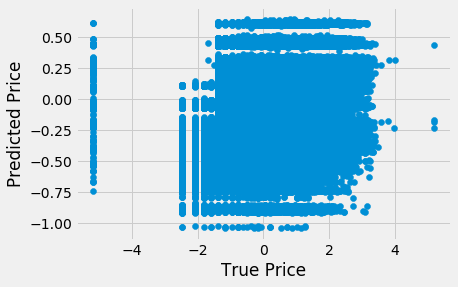

In [48]:
plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

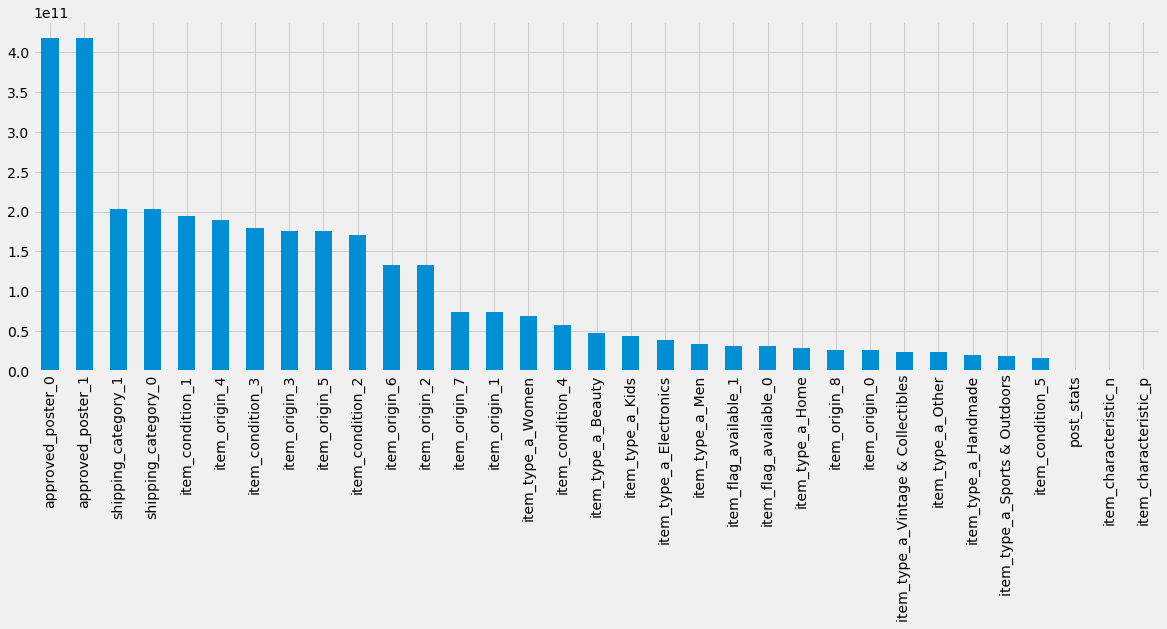

In [49]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Linear regression model

importance = pd.Series(np.abs(listing_pipeline.named_steps['linear regression'].coef_))
importance.index = list(X_train.columns)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

In [50]:
#try lasso Regression
from sklearn.linear_model import Lasso
listing_pipeline = Pipeline([
    # feature Scaling 
    ('scaler', StandardScaler()),
    
    # regression
    ('lasso', Lasso(random_state=0))
])

In [51]:
listing_pipeline.fit(X_train, y_train)

# let's get the predictions
X_train_preds = listing_pipeline.predict(X_train)
X_test_preds = listing_pipeline.predict(X_test)

In [52]:
#metrics for lasso Regression
print('train mse: {}'.format(mean_squared_error(y_train, X_train_preds)))
print('train rmse: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train r2: {}'.format(r2_score(y_train, X_train_preds)))
print()
print('test mse: {}'.format(mean_squared_error(y_test, X_test_preds)))
print('test rmse: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test r2: {}'.format(r2_score(y_test, X_test_preds)))

train mse: 0.9997937862628099
train rmse: 0.9998968878153437
train r2: 0.0

test mse: 1.0005456095195506
test rmse: 1.0002727675587049
test r2: -1.7444785909148663e-06


Text(0, 0.5, 'Predicted Price')

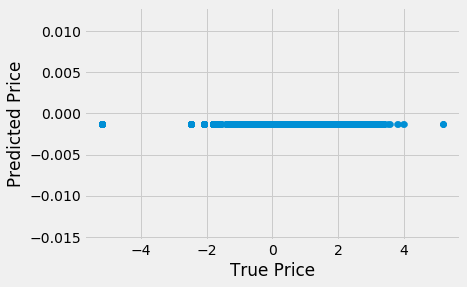

In [53]:
#for lasso 
plt.scatter(y_test,X_test_preds)
plt.xlabel('True Price')
plt.ylabel('Predicted Price')

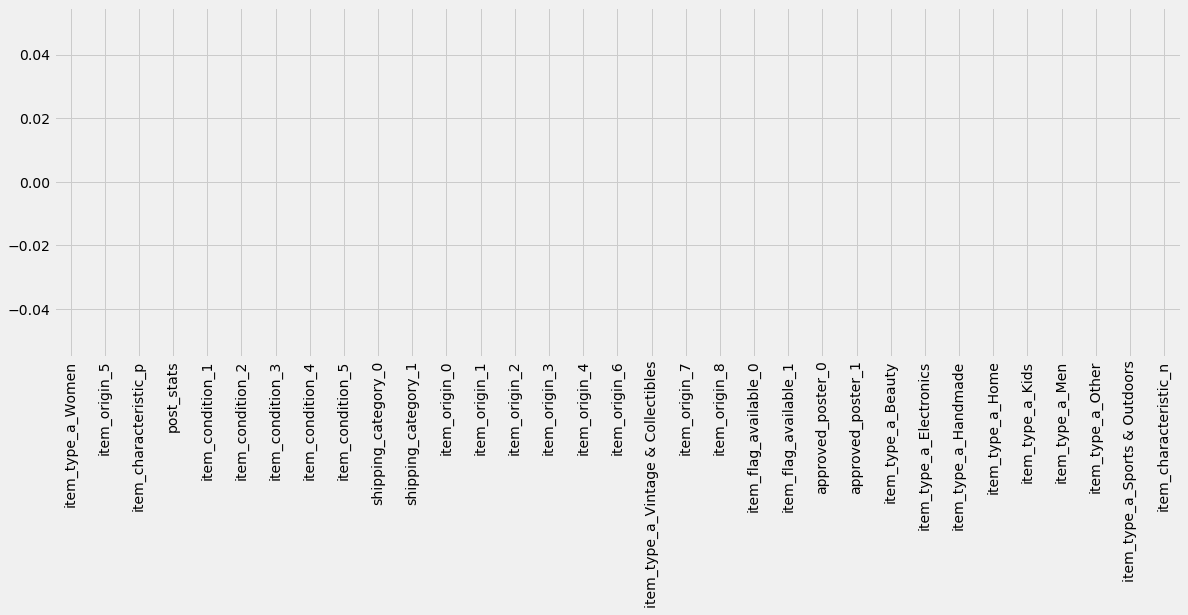

In [54]:
# let's explore the importance of the features
# the importance is given by the absolute value of the coefficient
# assigned by the Lasso

importance = pd.Series(np.abs(listing_pipeline.named_steps['lasso'].coef_))
importance.index = list(X_train.columns)
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))

### Using Cross validation

In [55]:
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
lin_reg = LinearRegression()
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lin_reg, features,target,cv = cv, scoring = 'neg_mean_absolute_error')

In [ ]:
print(f'The negative mean absolute error : {scores.mean()}')

As its name implies, negative MAE is simply the negative of the MAE, which (MAE) is by definition a positive quantity. And since MAE is an error metric, i.e. the lower the better, negative MAE is the opposite: a value of -2.6 is better than a value of -3.0.

In [ ]:
# for lasso 
lasso_reg = Lasso(random_state=0)
cv = KFold(shuffle=True, random_state=2, n_splits=10)
scores = cross_val_score(lasso_reg, features,target,cv = cv, scoring = 'neg_mean_absolute_error')
print(f'The negative mean absolute error : {scores.mean()}')

In this notebook i have sucessfulled performed multilinear Regression analysis. We can also explore Single Linear regression and which independent varaible best predicts the dependent variable price. 